Before you turn this lab in, make sure everything runs as expected. **Restart and run all cells** (in the menubar, select Kernel$\rightarrow$Restart & Run All) then check the output is as expected and there are no errors.  Also remember to **Save** before uploading this file (File$\rightarrow$Save and Checkpoint).

---

# <div align="center">Quantum Computer Systems Design</div>&nbsp;  <div align="center">Lab 7</div>

This lab will be very similar to the previous lab, except now you will account for error and variation in the hardware. In the interest of time you will only modify your scheduling pass to account for two things:

- Different coherence (T1) times of each qubit
- Crosstalk Error

Your objective will also be slightly different - last time your goal was to minimize the total execution time of the program and then to minimize total qubit use. Now we want to minimize the effect of decoherence and cross talk so we will be approximating success rate and the goal is to maximize this. You will be given programs which have been mapped and routed (you are welcome to use your own programs for testing).

The setup code is the same as before, so feel free to skip to part 0.

# 0.1. Programs For Development

Below is the same code from last lab which generates the Cuccarro Adder. You're welcome to use this circuit, which has been decomposed into 1 and 2 qubit gates, or any other as you develop your compilation passes. You can adjust the size of the below program `qiskit.transpile(generate_adder_circuit(4), basis_gates=['cx', 'rx', 'h', 'rz'])` by changing the `4` to some other even number for larger circuits. We suggest testing on small circuits however. Even simpler circuits containing only a small number of CNOTs may be beneficial. The grader tests might use programs you have not seen before.

In [1]:
import numpy as np
import itertools
import networkx as nx
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.quantumregister import Qubit
from IPython.display import display

from typing import Dict, Any, List, Tuple

In [2]:
# A test program for you to use during development.

# Implementation of the Cuccaro Quantum Adder from
#   https://github.com/jmbaker94/quantumcircuitbenchmarks
# Design from the paper
#   https://arxiv.org/abs/quant-ph/0410184

# Majority gate
maj_c = QuantumCircuit(3, name='MAJ')
maj_c.cx(2, 1)
maj_c.cx(2, 0)
maj_c.ccx(0, 1, 2)
maj = maj_c.to_gate(label='MAJ')

# 2-CNOT version of UnMajority and Add gate
uma2_c = QuantumCircuit(3, name='UMA2')
uma2_c.toffoli(0, 1, 2)
uma2_c.cx(2, 0)
uma2_c.cx(0, 1)
uma2 = uma2_c.to_gate(label='UMA2')

# 3-CNOT version of UnMajority and Add gate
# (Allows more parallelism in the circuit)
uma3_c = QuantumCircuit(3, name='UMA3')
uma3_c.x(1)
uma3_c.cx(0, 1)
uma3_c.toffoli(0, 1, 2)
uma3_c.x(1)
uma3_c.cx(2, 0)
uma3_c.cx(2, 1)
uma3 = uma3_c.to_gate(label='UMA3')

def cuccaro_adder(c, cin, a, b, cout, uma=uma3):
    c.append(maj, [cin, b[0], a[0]])
    for i in range(1, len(b)):
        c.append(maj, [a[i-1], b[i], a[i]])

    c.cx(a[-1], cout)

    for i in reversed(range(1, len(b))):
        c.append(uma, [a[i-1], b[i], a[i]])
    c.append(uma, [cin, b[0], a[0]])

def generate_adder_circuit(n, uma=uma3):
    if n % 2 != 0:
        raise ValueError('Odd number of qubits')

    qubits = QuantumRegister
    cin = range(1)
    a = range(1, n//2)
    b = range(n//2, n-1)
    cout = range(n-1, n)
    c = QuantumCircuit(n)
        
    cuccaro_adder(c, cin, a, b, cout, uma=uma)
    return c

def decomposed_adder_circuit(n):
    return qiskit.transpile(generate_adder_circuit(n),
                            basis_gates=['cx', 'rx', 'h', 'rz'])

print('Cuccaro Adder:')
display(generate_adder_circuit(8).draw(fold=-1))
cuccaro = decomposed_adder_circuit(8)
cuccaro.draw(fold=-1)

Cuccaro Adder:


┌──────┐                                       ┌───────┐
q_0: ┤0     ├───────────────────────────────────────┤0      ├
     │      │┌──────┐                      ┌───────┐│       │
q_1: ┤2     ├┤0     ├──────────────────────┤0      ├┤2      ├
     │      ││      │┌──────┐     ┌───────┐│       ││       │
q_2: ┤  MAJ ├┤2     ├┤0     ├─────┤0      ├┤2      ├┤  UMA3 ├
     │      ││      ││      │     │       ││       ││       │
q_3: ┤      ├┤  MAJ ├┤2     ├──■──┤2      ├┤  UMA3 ├┤       ├
     │      ││      ││      │  │  │       ││       ││       │
q_4: ┤1     ├┤      ├┤  MAJ ├──┼──┤  UMA3 ├┤       ├┤1      ├
     └──────┘│      ││      │  │  │       ││       │└───────┘
q_5: ────────┤1     ├┤      ├──┼──┤       ├┤1      ├─────────
             └──────┘│      │  │  │       │└───────┘         
q_6: ────────────────┤1     ├──┼──┤1      ├──────────────────
                     └──────┘┌─┴─┐└───────┘                  
q_7: ────────────────────────┤ X ├───────────────────────────
                             └───┘

global phase: 7π/4
          ┌───┐                                                                            ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌─────────┐        ┌───┐       
q_0: ─────┤ X ├────────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/4) ├───■──────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/4) ├───■────┤ X ├───────
          └─┬─┘┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  └──┬───┬──┘   │    ┌───┐         │                                                                         ┌─────────┐                                                                                                                                                                                                                                                                                                                 ┌─────────┐        ┌───┐  ┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  └──┬───┬──┘   │    └─┬─┘       
q_1: ──■────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼────┤ X ├─────────┼─────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/4) ├───■──────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/4) ├───■────┤ X ├──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼──────■──────■──
       │       └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘└──────────┘└───┘└─────────┘  │     └───┘      │    └─┬─┘  ┌───┐  │  ┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  └──┬───┬──┘   │    ┌───┐         │                                                                         ┌─────────┐                                                                                                ┌─────────┐        ┌───┐  ┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  └──┬───┬──┘   │    └─┬─┘  └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘└──────────┘└───┘└─────────┘  │     └───┘      │             │  
q_2: ──┼────■─────────┼────────────────────────────────┼────────────────────────────────┼────────────────┼──────■────┤ H ├──┼──┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼────┤ X ├─────────┼─────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/4) ├───■──────────────────■─────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/4) ├───■────┤ X ├──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼──────■──────■────┼────────────────────────────────┼────────────────────────────────┼────────────────┼─────────────┼──
       │    │         │                                │                                │    

# 0.2. Data Structures and Iterating through Qiskit Programs

Before you get started, let's build some basic data structures you may need for your passes. These objects are for your use, but you do not have to use them in your implementation of the below passes. You may want to modify the data structures to account for other parameters, such as gate times. It may be helpful to read through these functions to see how to manipulate `qiskit.QuantumCircuit`.

In [3]:
# 0.2.0 Wrapping Gates to Make them hashable in a graph structure and give them a unique identifying label
import dataclasses
@dataclasses.dataclass
class GateWrapper:
    gate:Any
    qubits:List[Qubit]
    extra_params:List[Any]
    label:str
        
    def __hash__(self):
        return hash((type(self.gate), tuple(self.qubits), self.label))
    
    def __str__(self):
        args = ','.join(str(q.index) for q in self.qubits)
        return f'{self.label}{{{self.gate.name}({args})}}'
    
    def __repr__(self):
        return str(self)

# 0.2.1 Building a new circuit from an old circuit (This is just to see how to use gates from old circuits)
def copy_a_circuit(old_circuit, n):
    '''
    QuantumCircuit's operate on registers of qubits. If the number of qubits in old_circuit is different from the number of qubits in the new circuit 
    you need to convert the qubits from old to new. 

    This function explains how to copy gates from one set of qubits to another in a different circuit.

    Args: 
        old_circuit: the circuit to copy
        n: number of qubits in the new circuit
            
    '''
    new_circuit = qiskit.QuantumCircuit(n)
    
    for gate in old_circuit:
        # If n = number of qubits in old_circuit this is O.K.
        # new_circuit.append(gate[0], gate[1], gate[2])
        
        # If n != number of qubits in old_circuit the above is NOT O.K.
        # Instead, convert the indices
        # DO NOT use both this and the above. 
        new_qubit_indices = [gate[1][i].index for i in range(len(gate[1]))]
        new_circuit.append(gate[0], new_qubit_indices, gate[2])
        
    return new_circuit

# 0.2.2 Building a Dependency Graph using NetworkX
def build_program_dependency_graph(circuit):
    '''
    Builds a program dependency graph like in the video. Feel free to modify this or build your own as you see fit.
    Here we convert the gates into their hashable versions and add a label.
    '''
    
    # Starting Label Index
    i = 0
    
    # A dictionary to store the last use of any qubit
    qubit_last_use = {}
    
    g = nx.DiGraph()
    
    # Add the start node
    g.add_node(-1)
    
    for gate in circuit:
        # Remember gate is a 3-tuple!
        
        hashable_gate = GateWrapper(gate[0], gate[1], gate[2], label=i)
        i += 1
        
        g.add_node(hashable_gate)
        
        # Add edges based on qubit_last_use; update last use
        for qubit in hashable_gate.qubits:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], hashable_gate)
            else:
                g.add_edge(-1, hashable_gate)
            
            qubit_last_use[qubit] = hashable_gate
            
    # Add the end node
    g.add_node(float('inf'))
    
    for qubit in qubit_last_use:
        g.add_edge(qubit_last_use[qubit], float('inf'))
            
    return g

# 0.2.3 From Dependency Graph with Hashable Gates to Qiskit Gates
def dependency_graph_to_circuit(dep_graph, n):
    '''
    Takes a dependency graph and the number of qubits n
    '''
    
    circuit = qiskit.QuantumCircuit(n)
    
    for gate in nx.topological_sort(dep_graph):
        
        if gate not in [-1, float('inf')]:
            circuit.append(gate.gate, gate.qubits, gate.extra_params)
            
    return circuit

# 0.2.4 Interaction Graphs
def interaction_graph_from_circuit(circuit):
    '''
    Builds a weighted interaction graph for a given circuit.

    Nodes are qubits
    Edges are weighted by the number of times pairs of qubits interact
    '''
    g = nx.Graph()
    
    for gate in circuit:
        for q in gate[1]:
            g.add_node(q)
            
        for i in range(len(gate[1])):
            for j in range(i):
                q1 = gate[1][i]
                q2 = gate[1][j]
                if q1 != q2:
                    if (q1, q2) not in g.edges:
                        g.add_edge(q1, q2, weight=1)
                    else:
                        g.edges[q1, q2]['weight'] += 1
        
    return g

# 0.2.5 Checking if a gate is a certain type
basic_c = QuantumCircuit(1)
basic_c.rz(np.pi / 2, 0)

for gate in basic_c:
    if isinstance(gate[0], qiskit.circuit.library.standard_gates.rz.RZGate):
        print("This is an RZ gate")

This is an RZ gate


In [4]:
# Helper functions to visualize
def draw_interaction_graph(ig):
    nx.draw(nx.relabel_nodes(ig, {q: f'{q.register.name}_{q.index}' for q in ig.nodes}),
            with_labels=True)

def draw_dependency_graph(dep_g):
    nx.draw(dep_g, with_labels=True)

def draw_hardware_graph(target_hardware):
    nx.draw(target_hardware, with_labels=True)

def draw_mapping(target_hardware, mapping):
    rev_mapping = {hw_q: None for hw_q in target_hardware.nodes}
    for k, v in mapping.items():
        assert v in rev_mapping, (
            'Invalid mapping: cannot map a circuit qubit to a non-existant hardware qubit '
            f'({k}->{v} but {v} does not exist)')
        assert rev_mapping[v] is None, (
            'Invalid mapping: cannot map two circuit qubits to the same qubit on hardware '
            f'({rev_mapping[v]}->{v} and {k}->{v})')
        rev_mapping[v] = k
    nx.draw(nx.relabel_nodes(target_hardware,
                             {hw_q: f'''q{getattr(rev_mapping[hw_q], 'index', None)
                                         }->{hw_q}'''
                              for hw_q in target_hardware.nodes}),
            with_labels=True)

def draw_routing(routed_circuit):
    routed_circuit.draw(fold=-1)

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\832072005.py:3: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  nx.draw(nx.relabel_nodes(ig, {q: f'{q.register.name}_{q.index}' for q in ig.nodes}),


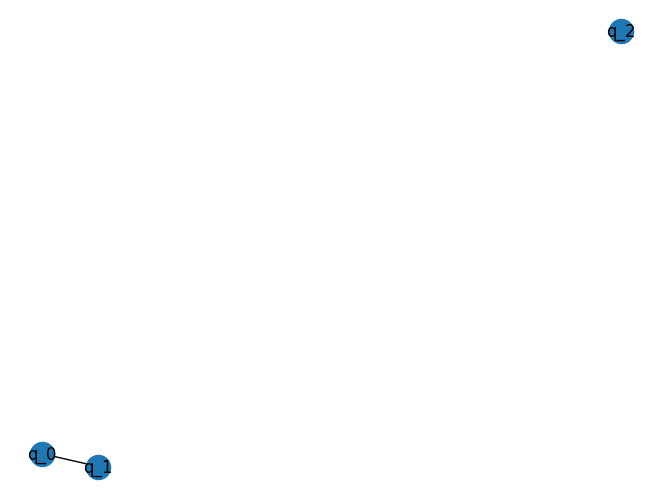

In [5]:
simple = QuantumCircuit(3)
simple.cx(0, 1)
simple.cx(1, 0)
simple.x(2)

ig = interaction_graph_from_circuit(simple)
dep_g = build_program_dependency_graph(simple)
draw_interaction_graph(ig)

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3593926637.py:14: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  args = ','.join(str(q.index) for q in self.qubits)


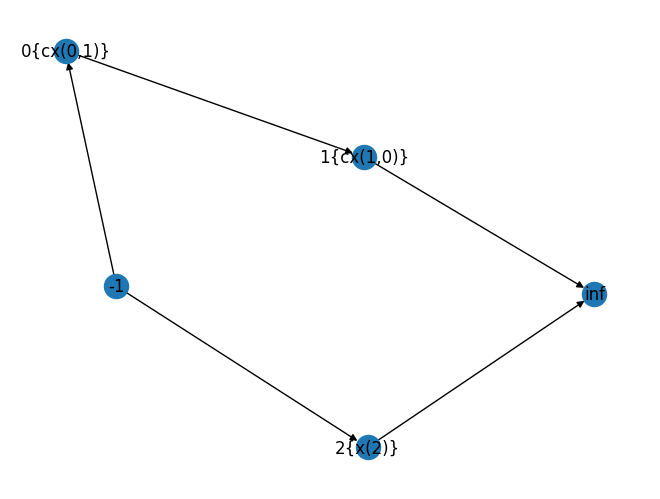

In [6]:
draw_dependency_graph(dep_g)

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\832072005.py:3: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  nx.draw(nx.relabel_nodes(ig, {q: f'{q.register.name}_{q.index}' for q in ig.nodes}),


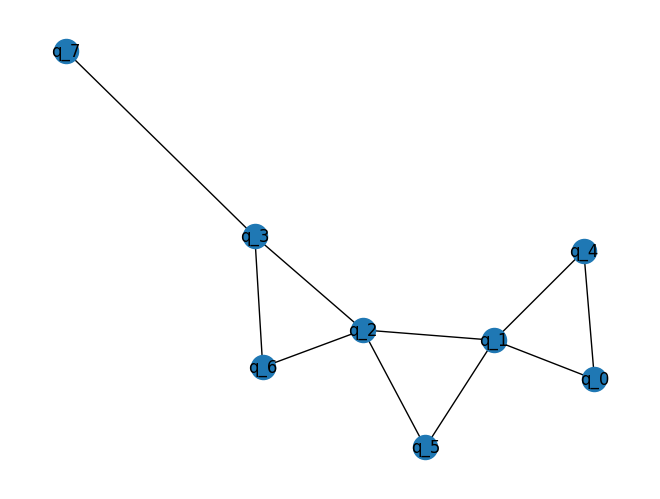

In [7]:
draw_interaction_graph(interaction_graph_from_circuit(cuccaro))

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3593926637.py:14: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  args = ','.join(str(q.index) for q in self.qubits)


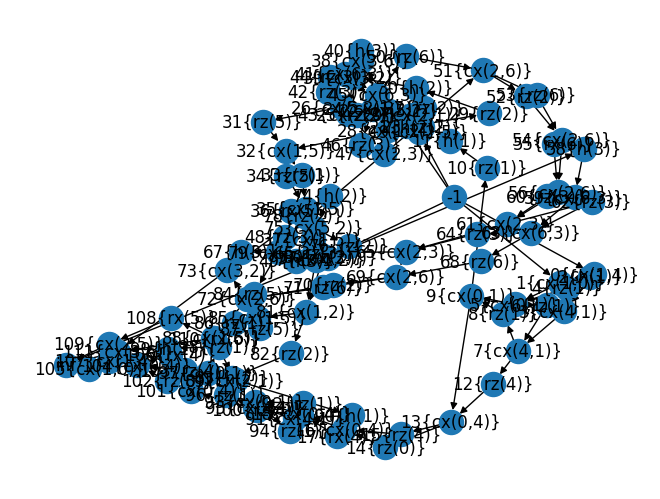

In [8]:
draw_dependency_graph(build_program_dependency_graph(cuccaro))

# 1. Noise-Aware Scheduling

For simplicity we will assume that gates executed on different qubits / pairs of qubits still execute in the same amount of time. However, the qubits themselves have different T1 times, reported as a dictionary `{hardware_qubit_i: T_1(hardware_qubit_i)}`. We will also assume that crosstalk error for CNOTs is reported as a value between 0 and 1 for pairs of edges. For example the success rate of gates executed in parallel on edge (u, v) and (w, x) could be given as 0.95. 

We approximate the probability that no coherence error occurs on a given qubit, $q$, with $T1(q)$ as:
    $$
        \epsilon_{T1(q)} = e^{-\text{Qubit Active Time} / {T1(q)}}
    $$
So minimizing the active time of the qubits is important, and even more so important for those with shorter T1 times.

You need to balance this minimization while making sure gates with high crosstalk do not overlap in time. For simplicity we will assume we incur the crosstalk error cost if two gates overlap at all (even partial overlaps). Therefore if $Q$ is our set of qubits and $X$ is the set of gates which occur in parallel with $\epsilon_{e_1, e_2}$ the crosstalk error of gate executing on hardware edge pair $e_1, e_2$, our goal is to maximize this function:
    $$
        \prod_{u \in Q} \epsilon_{T1(q)} \cdot \prod_{(e_1, e_2) \in X} \epsilon_{e_1, e_2}
    $$

In [23]:
def weight_list(ig):
    """
    Return a list of nodes in order max to min 
    """
    weights = []
    for node1, node2 in ig.edges:
        weight = ig[node1][node2]['weight']
        weights.append(((node1, node2), weight))
    weights.sort(key=lambda x: x[1], reverse=True)  
    #print("ESTOS SON LOS PESOS!!!! {}".format(weights))
    return weights


def short_path(target_hardware):
    """
    Return a dict af all the pairs with the shortest path 
    """
    return dict(nx.all_pairs_shortest_path_length(target_hardware)) 


def nodes_with_more_edges(target_hardware):
    """
    Return the degree of the node that has more edges (1,2)
    """
    max_node = sorted(target_hardware.degree, key=lambda x: x[1], reverse=True) #max(target_hardware.degree, key=lambda x: x[1])    
    return max_node


def neighbors(target_hardware, node):
    return list(target_hardware.neighbors(node))
    

def positioned_qubit(mapping, sw_node1: Qubit, sw_node2: Qubit, used_hardware: set, target_hardware):
    """
    Mapea el qubit logico al qubit fisico
    """
    nodes_more_edges = nodes_with_more_edges(target_hardware) # esto ya esta ordenado 
    hw_node = None
    # aca verificamos si ya esta o no mapeado el nodo OJO !!!
    if sw_node1 not in mapping:    
        for (hw, number_edges) in nodes_more_edges:
            if hw not in used_hardware:
                #print("Este es el nodo logico a ubicar{} nodo a usar {} numero de edges {}".format(sw_node1, hw, number_edges))
                mapping.update({sw_node1: hw})
                add_used_node(used_hardware, hw)   
                #print("1 MAPEO {}".format(mapping))
                break  

    hw_node = mapping[sw_node1]        

    if sw_node2 not in mapping:   
        neightbors = neighbors(target_hardware, hw_node)
        nodes_more_edges = filter_neightbor(nodes_more_edges, neightbors)
        #print("Estos son los nodos ordenados de manera max a menos{}".format(nodes_more_edges))
        for (hw, number_edges) in nodes_more_edges:
            if hw not in used_hardware:
                #print("HHHHHHHHHHHHHHHHHHHHHHHHHHHHh")
                #print("Este es el nodo logico a usar {} este el fisico {} numero de edges {}".format(sw_node2, hw, number_edges))
                mapping.update({sw_node2: hw})
                add_used_node(used_hardware, hw)
                #print("2 MAPEO {}".format(mapping))
                break   
                # verificar cual es el qubit con mas aristas retornalor
                # obtener el nodo verificar los vecinos del nodo que quiero ubicar 


def map_alone_qubits(graph, mapping,used_hardware, target_hardware): 
    # Verificar si hay nodos sueltos
    for node in graph.nodes:
        if node not in mapping:
            for hw in target_hardware:
                if hw not in used_hardware:
                    #print("Este es el nodo logico a ubicar{} nodo a usar {} numero de edges {}".format(sw_node1, hw, number_edges))
                    mapping.update({node: hw})
                    add_used_node(used_hardware, hw)   
                    #print("3 MAPEO {}".format(mapping))
                    break  

def add_used_node(used_node, node):
    """
    Mapea el qubit logico al qubit fisico
    """
    used_node.add(node)
    return used_node


def filter_neightbor(node_list, neighbor_list):
    # Filtrar los primeros elementos de las tuplas que estén en number_list
    result = [t for t in node_list if t[0] in neighbor_list]
    return result

In [11]:
def verify_has_neighbors(logic_q1, logic_q2, mapping, grid_hardware):
    # Creamos esta funcion que verifica si dos qubits son vecinos o no 
    physical_q1 = mapping.get(logic_q1)
    physical_q2 = mapping.get(logic_q2)
    
    if physical_q1 is None or physical_q2 is None:
        return False, physical_q1, physical_q2
    
    return grid_hardware.has_edge(physical_q1, physical_q2), physical_q1, physical_q2
    
def get_map_node_by_hw(hw_node,  mapping):
    for logic_node, mapped_hw_node in mapping.items():
        if mapped_hw_node == hw_node:
            return logic_node
    return None

def get_map_node_by_sw(_logic_node, mapping):
    for logic_node, mapped_hw_node in mapping.items():
        if logic_node.index == _logic_node.index:            
            return mapped_hw_node
    return None

def apply_swaps(circuit, path, mapping):  
    save_order = []
    qubit2 =None
    for i in range(len(path) - 2): # numero de swaps a aplicar
        qubit1_hw = path[i]
        qubit2_hw = path[i + 1]
        qubit1_logic = get_map_node_by_hw(qubit1_hw, mapping)
        qubit2_logic = get_map_node_by_hw(qubit2_hw, mapping)
        qubit1 =qubit1_logic.index
        qubit2= qubit2_logic.index
        circuit.swap(qubit1, qubit2)
        save_order.insert(0,(qubit1, qubit2))
    return qubit2, save_order
    
def reverse_swaps(circuit, save_order):
    for gate in save_order:
        circuit.swap(gate[0], gate[1])
    

In [12]:
### Optional: Copy your solutions from the previous lab
### for mapping and routing

def route_circuit(quantum_circuit:QuantumCircuit, target_hardware:nx.Graph,
                  mapping:Dict[Qubit, int]) -> QuantumCircuit:
    '''
    QuantumCircuit's operate on registers of qubits. If the number of qubits in old_circuit is different from the number of qubits in the new circuit 
    you need to convert the qubits from old to new. 

    This function explains how to copy gates from one set of qubits to another in a different circuit.

    Args: 
        old_circuit: the circuit to copy
        n: number of qubits in the new circuit
            
    '''
    new_circuit = qiskit.QuantumCircuit(len(target_hardware.nodes))
    
    for gate in quantum_circuit:
        gate_instruction, qubits , cbits = gate 
        if gate_instruction.name == 'cx':           
            has_neighbor, physical_q1, physical_q2 = verify_has_neighbors(qubits[0], qubits[1], mapping, target_hardware)
            sw_node_1 = [qubits[0].index]
            sw_node_2 = [qubits[1].index]
            if not has_neighbor: 
                path = nx.shortest_path(target_hardware, source=physical_q1, target=physical_q2)   
                qubit2, save_order = apply_swaps(new_circuit, path, mapping)    
                new_circuit.append(gate_instruction, [qubit2, sw_node_2], cbits)      
                reverse_swaps(new_circuit, save_order )    
            else: 
                new_qubit_indices = [gate[1][i].index for i in range(len(gate[1]))]
                new_circuit.append(gate[0], new_qubit_indices, gate[2])        
        else: 
            new_qubit_indices = [gate[1][i].index for i in range(len(gate[1]))]
            new_circuit.append(gate[0], new_qubit_indices, gate[2])
   
    new_circuit2 = qiskit.QuantumCircuit(len(target_hardware.nodes))
    for gate in new_circuit:

        _qubits = gate[1]
        new_qubit_indices =[]
        for i in range(len(_qubits)): 
            element = get_map_node_by_sw(_qubits[i], mapping)
            new_qubit_indices.append(element)     
        new_circuit2.append(gate[0], new_qubit_indices, gate[2])        
    return new_circuit2


def map_circuit(quantum_circuit:QuantumCircuit, target_hardware:nx.Graph
               ) -> Dict[Qubit, int]:
    '''
    This function should take an input program given as a
    qiskit.QuantumCircuit and a target hardware, given as a networkx
    graph and return a dictionary {qubit : hardware_id}

    The target_hardware graph is an undirected graph with nodes
    labeled 0 to n-1 where n is the total number of qubits.

    You should make sure there are enough hardware qubits to fit
    your program and raise an appropriate error otherwise.
    '''
    ### YOUR SOLUTION IN THIS FUNCTION
    ig = interaction_graph_from_circuit(quantum_circuit)
    assert len(ig.nodes) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'

    # Dictionary where keys are the index of qiskit qubit objects (type: int)
    # and values are target_hardware node ids (type: int)
    mapping:Dict[Qubit, int] = {}

    # 1. function para obtener los pesos de qubits logicos y que los ordene de mayor a menor done 
    weights = weight_list(ig)    
    # 2. funciton para obtener los nodos con la menor distancia a nivel fisico obtenerlos y si tienen la misma distancia cual escoger? escogemos de acuerdo al punto 3 
    # 3. funcion que determine donde ubicar al de mayor peso en el HW como determinamos esto? por la cantidad de edges que salen de un nodo 
    #print(short_path(target_hardware))
    #print(nodes_with_more_edges(target_hardware))

    # Other temp variables
    used_hardware = set()
    used_software = set()    

    for (logic_node1, logic_node2), weight in weights: 
        #print("node1: {} node2:{} weight:{}".format(logic_node1, logic_node2, weight))
        # Primero mapeamos los qubits que tienen edges
        positioned_qubit(mapping, logic_node1,logic_node2, used_hardware, target_hardware) 
        # Luego mapeamos todos los qubits que quedaron solitos
    map_alone_qubits(ig, mapping, used_hardware, target_hardware)

    # el primer nodo a ubicar debe ser puesto en el que tenga mas conexiones en el hw fisico
    # el segundo nodo debe estar si o si a la par entonces para ubicar el siguinet tomo la lista de nodos fisicos adyasentes a este 
    #print("Este es el mapeo {}".format(mapping))
    return mapping


In [13]:
# For simplicity, assume all 1 qubit gates have the same execution duration
# Except, assume Z gates are free, i.e. take no time to execute
# but you should still schedule Z gates at the appropriate time between other gates

# Here is some sample hardware. Feel free to change this for your testing.
# This is hardware with a simple linear connectivity 0 - 1 - 2 - ... - n-1
# Graphs with nodes numbered 0, 1, ..., n-1:
simple_hardware = nx.path_graph(8)
grid_hardware = nx.grid_2d_graph(2, 4)
grid_hardware = nx.relabel_nodes(grid_hardware, {n: i for i, n in enumerate(grid_hardware.nodes)})  # Relabel with integer indices

# Here are some sample gate times. These are in nanoseconds.
sample_gate_times = {
    '1' : 10.0,
    'rz' : 0.0,  # Free
    'cx' : 100.0,
}

# Here are some T1 times for the grid hardware above, randomly generated.
# Feel free to play around with these.
t1_low = 5e4
t1_high = 10e4

np.random.seed(1)
sample_T1_times = {
    i: np.random.uniform(t1_low, t1_high)
    for i in grid_hardware.nodes
}

# Here are some sample crosstalk errors for grid_hardware.
# These edges are NOT directional.
# So if (1, 2), (4, 5) is in the set so is (2, 1), (4, 5) etc.
# These pairs will be sorted so you don't have to try every permutation.
xtalk_low = 0.9
xtalk_high = 0.99

np.random.seed(2)
sample_xtalk_errors = {tuple(sorted([tuple(sorted(e1)), tuple(sorted(e2))])): v
                       for (e1, e2), v in {
    (e1, e2): np.random.uniform(xtalk_low, xtalk_high)
    # Example:
    #((1, 2), (4, 5)) : 0.95,
    #((0, 1), (3, 4)) : 0.9,
    #((0, 3), (1, 2)) : 0.98,
    for e1, e2 in itertools.combinations(grid_hardware.edges, 2)
}.items()}
def lookup_xtalk_error(error_dict, edge1, edge2):
    '''Use this method to lookup the crosstalk error from the above dictionary
    for a pair of CNOT gates.'''
    edge1 = tuple(sorted(edge1))
    edge2 = tuple(sorted(edge2))
    edges = tuple(sorted([edge1, edge2]))
    return error_dict[edges]

In [24]:
def build_program_dependency_graph(circuit: QuantumCircuit) -> nx.DiGraph:
    """
    Construye un grafo dirigido a partir de un circuito cuántico con dependencias de qubits y tiempos de ejecución.
    """
    dag = nx.DiGraph()
    num_qubits = circuit.num_qubits
    qubits_structure = [{i: {}} for i in range(num_qubits)]  # Estructura de seguimiento de qubits
    i = 0    

    for node in circuit.data:
        qiskit_gate = node[0]  # La compuerta (ejemplo: X, CX, Z)
        qubits = node[1]       # Qubits en los que actúa la compuerta
        clbits = node[2]       # Bits clásicos (si los hay) en este caso no hay del todo 
        label = f"gate_{i}"
        gate_wrapped = GateWrapper(qiskit_gate, qubits, clbits, label=label)

        if qiskit_gate.num_qubits == 1:
            dag.add_node(gate_wrapped, qubits=qubits, gate_name=qiskit_gate.name)
        else:  
            dag.add_node(gate_wrapped, qubits=qubits, gate_name=qiskit_gate.name)

        i += 1
    return dag


def crosstalk_error(qubits, gate_start_times, start_time, xtalk_errors, execution_time):
    q1, q2 = qubits[0].index, qubits[1].index
    for other_gate, other_start_time in gate_start_times.items():
        other_qubits = other_gate.qubits
        if len(other_qubits) == 2:
            other_q1, other_q2 = other_qubits[0].index, other_qubits[1].index            
            # Evitar comprobar el crosstalk en los mismos qubits
            if (q1, q2) == (other_q1, other_q2):
                continue            
            try:
                xtalk_error = lookup_xtalk_error(xtalk_errors, (q1, q2), (other_q1, other_q2))
            except KeyError:
                # Si no existe el par en el diccionario de errores, puedes continuar
                xtalk_error = 1.0  # En caso de que no hay crosstalk
            
            # Verificar si el error de crosstalk es alto
            if xtalk_error < 0.95:  # Si el crosstalk es alto, evitar el solapamiento OJO ACA
                start_time = max(start_time, other_start_time + execution_time)
    return start_time


def schedule_circuit(routed_circuit: QuantumCircuit, gate_times: Dict[str, float],
                     T1_times: Dict[int, float],
                     xtalk_errors: Dict[Tuple[Tuple[int, int], Tuple[int, int]], float]
                    ) -> Dict[GateWrapper, float]:
    '''
    Esta función toma un circuito cuántico como entrada, ya enrutado (QuantumCircuit).
    Retorna los tiempos de inicio de cada puerta del circuito como un diccionario: {GateWrapper: start_time}. OJO al tipo de dato de retorno
    '''
    
    # Convertir puertas SWAP a 3 CNOTs usando el PassManager de Qiskit
    pm = qiskit.transpiler.PassManager([qiskit.transpiler.passes.Unroller(['rz', 'rx', 'h', 'u3', 'cx'])])
    routed_circuit = pm.run(routed_circuit)

    # Grafo de dependencias
    dep_graph = build_program_dependency_graph(routed_circuit)

    gate_start_times: Dict[GateWrapper, float] = {}
    
    # Inicializar los tiempos finales de los qubits
    qubit_end_times = {i: 0.0 for i in range(routed_circuit.num_qubits)}
    
    # Iterar a través de las puertas en el grafo de dependencias
    for node in dep_graph.nodes(data=True):
        gate_wrapper = node[0]  # Nodo de tipo GateWrapper
        qubits = node[1]['qubits']  # Qubits afectados por la puerta
        gate_name = node[1]['gate_name']
        execution_time = gate_times.get(gate_name, gate_times['1'])
        
        # Determinar el tiempo de inicio de la puerta considerando el tiempo final de los qubits involucrados
        max_end_time = max(qubit_end_times[qubit] for qubit in [q.index for q in qubits])
        start_time = max_end_time
        
        # Comprobar el crosstalk si es una puerta de 2 qubits
        if len(qubits) == 2:
            start_time = crosstalk_error(qubits, gate_start_times, start_time, xtalk_errors, execution_time)
        
        # Asignar el tiempo de inicio a la puerta
        gate_start_times[gate_wrapper] = start_time
        
        # Actualizar los tiempos 
        for qubit in [q.index for q in qubits]:
            qubit_end_times[qubit] = start_time + execution_time

    return gate_start_times


In [25]:
# You may modify this cell to test scores for your mapper on various circuits

mapping = map_circuit(cuccaro, grid_hardware)
routed = route_circuit(cuccaro, grid_hardware, mapping)

# To test your implementation against other circuits, copy your
# mapping and routing solutions from the previous lab,
# uncomment the above lines, and remove the below line
#routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')

schedule = schedule_circuit(routed, sample_gate_times, sample_T1_times, sample_xtalk_errors)
#dict(list(schedule.items())) 
dict(list(schedule.items())[:20]+[('...', '...')])  # Only print first 20

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\587349541.py:23: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  sw_node_1 = [qubits[0].index]
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\587349541.py:24: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  sw_node_2 = [qubits[1].index]
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\587349541.py:31: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  new_qubit_indices = [gate[1][i].index for i in range(len(gate[1]))]
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\587349541.py:34: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been

{gate_0{cx(1,2)}: 0.0,
 gate_1{cx(0,4)}: 100.0,
 gate_2{cx(1,5)}: 200.0,
 gate_3{h(1)}: 300.0,
 gate_4{cx(2,1)}: 310.0,
 gate_5{rz(1)}: 410.0,
 gate_6{cx(5,1)}: 410.0,
 gate_7{rz(1)}: 510.0,
 gate_8{cx(2,1)}: 510.0,
 gate_9{rz(1)}: 610.0,
 gate_10{rz(2)}: 610.0,
 gate_11{cx(5,1)}: 610.0,
 gate_12{rz(1)}: 710.0,
 gate_13{h(1)}: 710.0,
 gate_14{cx(5,1)}: 720.0,
 gate_15{cx(1,5)}: 820.0,
 gate_16{cx(5,1)}: 920.0,
 gate_17{cx(1,2)}: 1020.0,
 gate_18{rz(2)}: 1120.0,
 gate_19{cx(5,1)}: 1120.0,
 '...': '...'}

In [26]:
# Do not modify this function
def schedule_to_circuit(schedule):
    qubits = set()
    for gate in schedule.keys():
        qubits.update(gate.qubits)
    n = len(qubits)
    circuit = QuantumCircuit(next(iter(qubits)).register)
    ordered = sorted(((time, gate)
                      for gate, time in schedule.items()),
                     key=lambda x:(x[0], x[1].gate.name!='rz'))
    for time, gate in ordered:
        new_qubits = [circuit.qubits[q.index] for q in gate.qubits]
        circuit.append(gate.gate, new_qubits, [])
    return circuit

# Make sure the schedule still represents the original circuit
schedule_to_circuit(schedule).draw(fold=-1)

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\741747216.py:7: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  circuit = QuantumCircuit(next(iter(qubits)).register)
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\741747216.py:12: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  new_qubits = [circuit.qubits[q.index] for q in gate.qubits]


┌───┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌───┐     ┌───┐        ┌───┐         ┌───┐           ┌───┐     ┌───┐       ┌───┐       ┌───┐┌───┐     ┌───┐     ┌───┐     ┌───┐┌───┐                    ┌───┐                                                                 ┌───┐          ┌───┐                                                   ┌───┐          ┌───┐                                                                                  ┌───┐     ┌─────────┐     ┌───┐                                                                               ┌───┐          ┌───┐                                                                                               ┌───┐                         ┌───┐                                                                 ┌───┐          ┌───┐                                                   ┌───┐          ┌───┐                                                                                  ┌───┐     ┌─────────┐     ┌───┐                                                                               ┌───┐                    ┌───┐┌───┐          ┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌───┐     ┌───┐        ┌───┐         ┌───┐           ┌───┐     ┌───┐       ┌───┐       ┌───┐                                                                                                                                                                                                      
q_0: ───────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ H ├┤ X ├──■──┤ X ├──■─────┤ X ├──────■──┤ X ├───────────┤ X ├──■──┤ X ├──■────┤ X ├────■──┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├─────────────────■──┤ X ├──■───────────────────────────────────────────────────────────■──┤ X ├──■────■──┤ X ├──■─────────────────────────────────────────────■──┤ X ├──■────■──┤ X ├──■────────────────────────────────────────────────────────────────────────────■──┤ X ├──■──┤ Rz(π/4) ├──■──┤ X ├──■─────────────────────────────────────────────────────────────────────────■──┤ X ├──■────■──┤ X ├──■────────────────────────────────────────────────────────────────────────────────────■───────┤ X ├───────■─────────■───────┤ X ├──■───────────────────────────────────────────────────────────■──┤ X ├──■────■──┤ X ├──■─────────────────────────────────────────────■──┤ X ├──■────■──┤ X ├──■────────────────────────────────────────────────────────────────────────────■──┤ X ├──■──┤ Rz(π/4) ├──■──┤ X ├──■─────────────────────────────────────────────────────────────────────────■──┤ X ├──■─────────────────┤ X ├┤ H ├──────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ H ├┤ X ├──■──┤ X ├──■─────┤ X ├──────■──┤ X ├───────────┤ X ├──■──┤ X ├──■────┤ X ├────■──┤ X ├──■─────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            │       ┌───┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌──────────┐┌───┐┌─────────┐┌───┐┌───┐     ┌───┐                 ┌───┐     ┌───┐           ┌───┐     ┌───┐              ┌───┐     ┌───┐┌───┐     ┌───┐     ┌───┐     ┌───┐┌─┴─┐└───┘└─┬─┘└──────────┘└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘└─────────┘└───┘└─┬─┘┌─┴─┐└─┬─┘  │     └─┬─┘    ┌─┴─┐└─┬─┘┌─────────┐└─┬─┘┌─┴─┐└─┬─┘  │    └─┬─┘  ┌─┴─┐└─┬─┘└─┬─┘┌─┴─┐└─┬─┘  │  └─┬─┘┌─┴─┐└─┬─┘└─┬─┘                 │  └─┬─┘  │                                                           │  └─┬─┘  │    │  └─┬─┘  │                                             │  └─┬─┘  │    │  └─┬─┘  │                                                                            │  └─┬─┘  │  └─────────┘  │  └─┬─┘  │                                               

In [27]:
# Do not delete this cell
def validate_schedule(routed_circuit, gate_times, schedule, check_unitary=True):
    '''Set check_unitary=False for circuits with over 10 qubits.'''
    # Check other arguments
    assert isinstance(routed_circuit, QuantumCircuit)
    assert isinstance(gate_times, dict)
    assert isinstance(schedule, dict)
    assert (len(routed_circuit.qubits)
            == len(frozenset(q.index for q in routed_circuit.qubits))), (
        'Unsupported: circuits with multiple registers')
    # Convert schedule back to a circuit
    s_circuit = schedule_to_circuit(schedule)
    r_qubits = frozenset(q for q in routed_circuit.qubits)
    s_qubits = frozenset(q for q in routed_circuit.qubits)
    assert r_qubits == s_qubits, 'schedule has different qubits than the circuit'
    # Check allowed gates
    for gate in schedule.keys():
        if len(gate.qubits) < 2: continue
        assert len(gate.qubits) <= 2, (
            'Only one- and two-qubit gates are allowed in the schedule')
        assert isinstance(gate.gate, qiskit.circuit.library.standard_gates.x.CXGate), (
            'Two-qubit gates other than CNOT are not allwed in the schedule')
    # Check for overlapping gates
    sorted_schedule = sorted(schedule.items(), key=lambda x:x[1])
    for i, (gate, time) in enumerate(sorted_schedule):
        end_time = time + gate_times.get(gate.gate.name, gate_times['1'])
        j = 0
        for j in range(i+1, len(sorted_schedule)):
            if sorted_schedule[j][1] >= end_time: break
        nearby_gates = sorted_schedule[i+1:j]
        left = max((
            t2 + gate_times.get(g2.gate.name, gate_times['1'])
            for g2, t2 in nearby_gates
            if (t2 + gate_times.get(g2.gate.name, gate_times['1']) < end_time
                and len(set(gate.qubits).intersection(g2.qubits)) > 0)
                and g2 != gate),
            default=0
        )
        right = min((
            t2
            for g2, t2 in nearby_gates
            if ((t2 > time or (
                    gate_times.get(g2.gate.name, gate_times['1']) != 0
                    and t2 >= time))
                and len(set(gate.qubits).intersection(g2.qubits)) > 0)
                and g2 != gate),
            default=float('inf')
        )
        #print(left, right)
        assert left <= time+1e-8 and right >= end_time-1e-8, (
            'At least one gate is scheduled during the same time on the same qubits '
            f'(at time {time} - {end_time}, gate={gate})')
        
    # Check unitary
    if check_unitary:  # Slow for circuits with more than 10 qubits
        from qiskit.quantum_info.operators.predicates import matrix_equal
        unitary = lambda c: qiskit.quantum_info.Operator(c).data
        assert matrix_equal(unitary(s_circuit), unitary(routed_circuit)), (
            'schedule is not equivalent to the input circuit')

def total_schedule_active_times(routed_circuit, gate_times, schedule):
    total_duration = max((
        time + gate_times.get(gate.gate.name, gate_times['1'])
        for gate, time in schedule.items()),
        default=0
    )
    first_use_each_qubit = {
        q: min((time for gate, time in schedule.items()
                     if q in gate.qubits),
               default=total_duration)
        for q in routed_circuit.qubits
    }
    qubit_usage_times = {
        q: total_duration - first_use
        for q, first_use in first_use_each_qubit.items()
    }
    total_active = sum(qubit_usage_times.values())
    
    num_used_qubits = sum(t > 0 for t in qubit_usage_times.values())
    worst_serial_time = sum(
        gate_times.get(gate.gate.name, gate_times['1'])
        for gate in schedule.keys()
    )
    #print(f'(Total circuit duration is {total_duration})')
    #print(f'Qubit active durations:\n{qubit_usage_times}')
    return qubit_usage_times, worst_serial_time

def total_schedule_cross_talk(routed_circuit, gate_times, schedule, xtalk_errors):
    cx_dur = gate_times['cx']
    cx_times_list = [
        (time, time+cx_dur, frozenset(q.index for q in gate.qubits))
        for gate, time in schedule.items()
        if gate.gate.name == 'cx'  # Only count crosstalk for CNOT gates
    ]
    cx_times_list.sort()

    xtalk_list = []
    for i, (start1, end1, qubits1) in enumerate(cx_times_list):
        for j in range(i+1, len(cx_times_list)):
            start2, end2, qubits2 = cx_times_list[j]
            if start2 < end1-1e-8:  # Overlap in time -> crosstalk
                key = tuple(sorted([tuple(sorted(qubits1)), tuple(sorted(qubits2))]))
                xtalk_list.append(xtalk_errors.get(key, 1))
            else:
                break
    return xtalk_list

def score_schedule(routed_circuit, gate_times, schedule, t1_times, xtalk_errors):
    '''
    Computes the active qubit time of the schedule.
    
    Returns the tuple (your score, worst-case serial score).  Lower values are better.
    '''
    validate_schedule(routed_circuit, gate_times, schedule, check_unitary=False)

    # Coherence time error estimate
    qubit_usage_times, worst_serial_time = total_schedule_active_times(
            routed_circuit, gate_times, schedule)
    total_duration = max(qubit_usage_times.values())
    total_active = sum(qubit_usage_times.values())
    each_coherence = {
        q.index: np.exp(-t/t1_times[q.index])
        for q, t in qubit_usage_times.items()
    }
    coherence_success = np.prod(list(each_coherence.values()))

    # Crosstalk error estimate
    xtalk_list = total_schedule_cross_talk(
            routed_circuit, gate_times, schedule, xtalk_errors)
    xtalk_success = np.prod(xtalk_list)
    
    # Total
    score = coherence_success * xtalk_success
    
    # Compute worst serialized schedule score
    serial_each_coherence = {
        q.index: np.exp(-worst_serial_time/t1_times[q.index])
        for q, _ in qubit_usage_times.items()
    }
    serial_coherence_success = np.prod(list(serial_each_coherence.values()))
    serial_xtalk_success = 1.0
    worst_serial_score = serial_coherence_success * serial_xtalk_success
    
    print(f'(Total circuit duration is {total_duration})')
    print(f'({len(t1_times)} qubit coherence times ranging from {min(t1_times.values())} to {max(t1_times.values())})')
    #print(f'Crosstalk list: {xtalk_list}')
    #print(f'Usage times: {t1_times}')
    #print(f'Each coherence: {each_coherence}')
    print(f'Coherence success rate: {coherence_success} (P(error)={1-coherence_success})')
    print(f'Crosstalk success rate: {xtalk_success} (P(error)={1-xtalk_success})')
    print(f'Overall success rate: {score}')
    print()
    print(f'Your scheduling score is P(success)={score}')
    print(f'(worst case serialized score would be {worst_serial_score})')
    return score, worst_serial_score

In [28]:
# You may modify this cell to test scores for your mapper on various circuits

#mapping = map_circuit(cuccaro, grid_hardware)
#routed = route_circuit(cuccaro, grid_hardware, mapping)

# To test your implementation against other circuits, copy your
# mapping and routing solutions from the previous lab,
# uncomment the above lines, and remove the below line
routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')

schedule = schedule_circuit(routed, sample_gate_times, sample_T1_times, sample_xtalk_errors)
score_schedule(routed, sample_gate_times, schedule, sample_T1_times, sample_xtalk_errors)

(Total circuit duration is 20660.0)
(8 qubit coherence times ranging from 50005.71874086725 to 86016.2246721079)
Coherence success rate: 0.11421768830415237 (P(error)=0.8857823116958476)
Crosstalk success rate: 0.9422199794309106 (P(error)=0.057780020569089374)
Overall success rate: 0.10761818792458461

Your scheduling score is P(success)=0.10761818792458461
(worst case serialized score would be 0.06738362588013197)


C:\Users\panch\AppData\Local\Temp\ipykernel_21532\1135842391.py:76: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  max_end_time = max(qubit_end_times[qubit] for qubit in [q.index for q in qubits])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\1135842391.py:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q1, q2 = qubits[0].index, qubits[1].index
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\1135842391.py:87: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  for qubit in [q.index for q in qubits]:
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\1135842391.py:31: DeprecationWarning: Back-references to from Bit instances

(0.10761818792458461, 0.06738362588013197)

In [19]:
# Do not delete this cell
# The autograder will test the function schedule_circuit.
# This test is worth more points than the other parts
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(2, 4)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(724940)
_t1_times = {
    i: np.random.randint(4e4, 14e4)
    for i in _hardware.nodes
}
_xtalk_errors = {
    tuple(sorted([e1, e2])): np.random.uniform(0.85, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule)
score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
print('\nPASS: Valid circuit schedule')

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:79: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  max_end_time = max(qubit_end_times[qubit] for qubit in [q.index for q in qubits])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q1, q2 = qubits[0].index, qubits[1].index
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:90: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  for qubit in [q.index for q in qubits]:
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:31: DeprecationWarning: Back-references to from Bit instances

(Total circuit duration is 16472.0)
(8 qubit coherence times ranging from 46341 to 126789)
Coherence success rate: 0.3245934752182146 (P(error)=0.6754065247817854)
Crosstalk success rate: 0.9016965568157026 (P(error)=0.0983034431842974)
Overall success rate: 0.2926848189691072

Your scheduling score is P(success)=0.2926848189691072
(worst case serialized score would be 0.21604888027264832)

PASS: Valid circuit schedule


C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:122: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q.index: np.exp(-t/t1_times[q.index])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:91: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  (time, time+cx_dur, frozenset(q.index for q in gate.qubits))
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:137: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q.index: np.exp(-worst_serial_time/t1_times[q.index])


In [20]:
# Do not delete this cell
# The autograder will test the how well you reduce T1 decoherence error.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(2, 4)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(724940)
_t1_times = {
    i: np.random.randint(4e4, 14e4)
    for i in _hardware.nodes
}
_xtalk_errors = {  # No crosstalk errors in this test
    tuple(sorted([e1, e2])): 1 #np.random.uniform(0.85, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
assert 0.21604888 <= _worst <= 0.21604889, 'internal error'
assert _score >= 0.25, 'score is below P=0.25, try improving the schedule by scheduling gates sooner if possible'
print('\nPASS: Score is above P=0.25 (see if you can beat our score of 0.3211)')

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:79: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  max_end_time = max(qubit_end_times[qubit] for qubit in [q.index for q in qubits])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q1, q2 = qubits[0].index, qubits[1].index
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:90: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  for qubit in [q.index for q in qubits]:
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:31: DeprecationWarning: Back-references to from Bit instances

(Total circuit duration is 15328.0)
(8 qubit coherence times ranging from 46341 to 126789)
Coherence success rate: 0.28845380034042273 (P(error)=0.7115461996595773)
Crosstalk success rate: 1 (P(error)=0)
Overall success rate: 0.28845380034042273

Your scheduling score is P(success)=0.28845380034042273
(worst case serialized score would be 0.21604888027264832)

PASS: Score is above P=0.25 (see if you can beat our score of 0.3211)


C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:122: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q.index: np.exp(-t/t1_times[q.index])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:91: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  (time, time+cx_dur, frozenset(q.index for q in gate.qubits))
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:137: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q.index: np.exp(-worst_serial_time/t1_times[q.index])


In [21]:
# Do not delete this cell
# The autograder will test the how well you reduce T1 decoherence error again.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(2, 4)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(724940)
_t1_times = {
    i: np.random.randint(4e4, 14e4)
    for i in _hardware.nodes
}
_xtalk_errors = {  # No crosstalk errors in this test
    tuple(sorted([e1, e2])): 1 #np.random.uniform(0.85, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
assert 0.21604888 <= _worst <= 0.21604889, 'internal error'
assert _score >= 0.30, 'score is below P=0.30, try improving the schedule by scheduling gates sooner if possible'
print('\nPASS: Score is above P=0.30 (see if you can beat our score of 0.3211)')

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:79: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  max_end_time = max(qubit_end_times[qubit] for qubit in [q.index for q in qubits])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q1, q2 = qubits[0].index, qubits[1].index
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:90: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  for qubit in [q.index for q in qubits]:
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:31: DeprecationWarning: Back-references to from Bit instances

(Total circuit duration is 15328.0)
(8 qubit coherence times ranging from 46341 to 126789)
Coherence success rate: 0.28845380034042273 (P(error)=0.7115461996595773)
Crosstalk success rate: 1 (P(error)=0)
Overall success rate: 0.28845380034042273

Your scheduling score is P(success)=0.28845380034042273
(worst case serialized score would be 0.21604888027264832)


AssertionError: score is below P=0.30, try improving the schedule by scheduling gates sooner if possible

In [ ]:
# Do not delete this cell
# The autograder will test the how well you reduce crosstalk error.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(2, 4)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(724940)
_t1_times = {  # No decoherence errors in this test
    i: np.inf * np.random.randint(4e4, 14e4)
    for i in _hardware.nodes
}
_xtalk_errors = {  
    tuple(sorted([e1, e2])): np.random.uniform(0.85, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
# The worst-case serialized score is a perfect 1.0 because it already avoids all crosstalk
assert _worst == 1.0, 'internal error'
assert _score >= 0.10, 'score is below P=0.10, try improving the schedule by not scheduling CNOT gates at the same time'
print('\nPASS: Score is above P=0.10 (see if you can beat our score of 1.0)')

In [ ]:
# Do not delete this cell
# The autograder will test the how well you reduce crosstalk error again.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(2, 4)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(724940)
_t1_times = {  # No decoherence errors in this test
    i: np.inf * np.random.randint(4e4, 14e4)
    for i in _hardware.nodes
}
_xtalk_errors = {  
    tuple(sorted([e1, e2])): np.random.uniform(0.85, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
# The worst-case serialized score is a perfect 1.0 because it already avoids all crosstalk
assert _worst == 1.0, 'internal error'
assert _score >= 0.50, 'score is below P=0.50, try improving the schedule by not scheduling CNOT gates at the same time'
print('\nPASS: Score is above P=0.50 (see if you can beat our score of 1.0)')

In [ ]:
# Do not delete this cell
# The autograder will test the how well you reduce both kinds of error at once.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(2, 4)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(724940)
_t1_times = {
    i: np.random.randint(4e4, 14e4)
    for i in _hardware.nodes
}
_xtalk_errors = {  
    tuple(sorted([e1, e2])): np.random.uniform(0.85, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
assert 0.21604888 <= _worst <= 0.21604889, 'internal error'
assert _score >= 0.22, 'score is below P=0.22, try improving the schedule'
print('\nPASS: Score is above P=0.22 (see if you can beat our score of 0.3211)')

In [ ]:
# Do not delete this cell
# The autograder will test the how well you reduce both kinds of error at once.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(2, 4)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[0],q[1];\ncx q[0],q[4];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\ncx q[6],q[5];\ncx q[6],q[2];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[7];\nh q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[6];\ncx q[5],q[6];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nrz(pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[1],q[2];\ncx q[1],q[5];\nswap q[1],q[2];\ncx q[6],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[4],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[1];\nswap q[0],q[4];\ncx q[0],q[1];\nswap q[0],q[4];\ncx q[0],q[4];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[2],q[3];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[6],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(724940)
_t1_times = {
    i: np.random.randint(4e4, 14e4)
    for i in _hardware.nodes
}
_xtalk_errors = {  
    tuple(sorted([e1, e2])): np.random.uniform(0.85, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
assert 0.21604888 <= _worst <= 0.21604889, 'internal error'
assert _score >= 0.28, 'score is below P=0.28, try improving the schedule'
print('\nPASS: Score is above P=0.28 (see if you can beat our score of 0.3211)')

In [ ]:
# Do not delete this cell
# The autograder will test with bigger circuits now.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(6, 6)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[36];\ncx q[0],q[1];\ncx q[0],q[6];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(pi/4) q[6];\nrz(-pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[8],q[7];\ncx q[8],q[2];\nh q[8];\ncx q[7],q[8];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nrz(pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[7];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[9],q[10];\ncx q[9],q[8];\nh q[9];\ncx q[10],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[10],q[9];\nrz(pi/4) q[10];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-pi/4) q[10];\nrz(pi/4) q[8];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(2.6375741) q[10];\nrx(pi) q[10];\nrz(2.6375741) q[10];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[15],q[14];\ncx q[15],q[9];\nh q[15];\ncx q[14],q[15];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nrz(pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[14];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-pi/4) q[14];\nrz(pi/4) q[9];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(2.6375741) q[14];\nrx(pi) q[14];\nrz(2.6375741) q[14];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\ncx q[16],q[17];\ncx q[16],q[15];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-pi/4) q[17];\nrz(pi/4) q[15];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\ncx q[22],q[21];\ncx q[22],q[16];\nh q[22];\ncx q[21],q[22];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nrz(pi/4) q[22];\ncx q[21],q[22];\nrz(pi/4) q[21];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-pi/4) q[21];\nrz(pi/4) q[16];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\ncx q[23],q[29];\ncx q[23],q[22];\nh q[23];\ncx q[29],q[23];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nrz(pi/4) q[23];\ncx q[29],q[23];\nrz(pi/4) q[29];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-pi/4) q[29];\nrz(pi/4) q[22];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-5*pi/4) q[23];\nrx(pi/2) q[23];\nrz(pi/2) q[23];\ncx q[11],q[5];\nswap q[17],q[11];\ncx q[17],q[23];\nswap q[17],q[11];\nh q[11];\ncx q[5],q[11];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nrz(pi/4) q[11];\ncx q[5],q[11];\nrz(pi/4) q[5];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-pi/4) q[5];\nrz(pi/4) q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nswap q[10],q[4];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[4];\nswap q[10],q[4];\ncx q[10],q[11];\nswap q[10],q[4];\nh q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(pi/4) q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(pi/4) q[28];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(-pi/4) q[28];\nrz(pi/4) q[11];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\ncx q[13],q[12];\nswap q[7],q[13];\nswap q[1],q[7];\nswap q[2],q[1];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[7];\nswap q[7],q[13];\nh q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(2.6375741) q[12];\nrx(pi) q[12];\nrz(2.6375741) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\ncx q[19],q[18];\ncx q[19],q[13];\nh q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(pi/4) q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(-5*pi/4) q[19];\nrx(pi/2) q[19];\nrz(pi/2) q[19];\nrz(pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(pi/4) q[13];\nrz(-pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\ncx q[20],q[26];\ncx q[20],q[19];\nh q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(pi/4) q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(pi/4) q[19];\nrz(-pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\ncx q[25],q[24];\nswap q[19],q[25];\ncx q[19],q[20];\nswap q[19],q[25];\nh q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(pi/4) q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(-5*pi/4) q[25];\nrx(pi/2) q[25];\nrz(pi/2) q[25];\nrz(pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\ncx q[31],q[30];\ncx q[31],q[25];\nh q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(pi/4) q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(-5*pi/4) q[31];\nrx(pi/2) q[31];\nrz(pi/2) q[31];\nrz(pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(pi/4) q[25];\nrz(-pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\ncx q[32],q[33];\ncx q[32],q[31];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(pi/4) q[31];\nrz(-pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[33],q[27];\ncx q[33],q[34];\nswap q[33],q[27];\nswap q[26],q[27];\ncx q[26],q[32];\nswap q[26],q[27];\nh q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(pi/4) q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(-5*pi/4) q[27];\nrx(pi/2) q[27];\nrz(pi/2) q[27];\nrz(pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(pi/4) q[32];\nrz(-pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nswap q[33],q[27];\nswap q[34],q[33];\ncx q[34],q[35];\nswap q[34],q[33];\nswap q[33],q[27];\nh q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(pi/4) q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(-5*pi/4) q[27];\nrx(pi/2) q[27];\nrz(pi/2) q[27];\nrz(pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(pi/4) q[32];\nrz(-pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nswap q[26],q[27];\ncx q[26],q[32];\nswap q[26],q[27];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(pi/4) q[31];\nrz(-pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\ncx q[32],q[31];\nh q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(pi/4) q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(-5*pi/4) q[31];\nrx(pi/2) q[31];\nrz(pi/2) q[31];\nrz(pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(pi/4) q[25];\nrz(-pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\ncx q[31],q[25];\nh q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(pi/4) q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(-5*pi/4) q[25];\nrx(pi/2) q[25];\nrz(pi/2) q[25];\nrz(pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nswap q[19],q[25];\ncx q[19],q[20];\nswap q[19],q[25];\nh q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(pi/4) q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(pi/4) q[19];\nrz(-pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\ncx q[20],q[19];\nh q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(pi/4) q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(-5*pi/4) q[19];\nrx(pi/2) q[19];\nrz(pi/2) q[19];\nrz(pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(pi/4) q[13];\nrz(-pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\ncx q[19],q[13];\nh q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nswap q[7],q[13];\nswap q[1],q[7];\nswap q[2],q[1];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[7];\nswap q[7],q[13];\nh q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(2.6375741) q[12];\nrx(pi) q[12];\nrz(2.6375741) q[12];\ncx q[13],q[12];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[19],q[18];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\ncx q[20],q[26];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\ncx q[25],q[24];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[31],q[30];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[32],q[33];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\nswap q[33],q[27];\ncx q[33],q[34];\nswap q[33],q[27];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(pi/4) q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(pi/4) q[28];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(-pi/4) q[28];\nrz(pi/4) q[11];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nswap q[10],q[4];\ncx q[10],q[11];\nswap q[10],q[4];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\nswap q[10],q[4];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[4];\nh q[11];\ncx q[5],q[11];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nrz(pi/4) q[11];\ncx q[5],q[11];\nrz(pi/4) q[5];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-pi/4) q[5];\nrz(pi/4) q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nswap q[17],q[11];\ncx q[17],q[23];\nswap q[17],q[11];\nh q[23];\ncx q[29],q[23];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nrz(pi/4) q[23];\ncx q[29],q[23];\nrz(pi/4) q[29];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-pi/4) q[29];\nrz(pi/4) q[22];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\nrz(-5*pi/4) q[23];\nrx(pi/2) q[23];\nrz(pi/2) q[23];\ncx q[23],q[22];\nh q[22];\ncx q[21],q[22];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nrz(pi/4) q[22];\ncx q[21],q[22];\nrz(pi/4) q[21];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-pi/4) q[21];\nrz(pi/4) q[16];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\ncx q[22],q[16];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-pi/4) q[17];\nrz(pi/4) q[15];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\ncx q[16],q[15];\nh q[15];\ncx q[14],q[15];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nrz(pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[14];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-pi/4) q[14];\nrz(pi/4) q[9];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(2.6375741) q[14];\nrx(pi) q[14];\nrz(2.6375741) q[14];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\ncx q[15],q[9];\nh q[9];\ncx q[10],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[10],q[9];\nrz(pi/4) q[10];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-pi/4) q[10];\nrz(pi/4) q[8];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(2.6375741) q[10];\nrx(pi) q[10];\nrz(2.6375741) q[10];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[9],q[8];\nh q[8];\ncx q[7],q[8];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nrz(pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[7];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[8],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(pi/4) q[6];\nrz(-pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\ncx q[0],q[6];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\ncx q[2],q[3];\ncx q[8],q[7];\ncx q[9],q[10];\ncx q[15],q[14];\ncx q[16],q[17];\ncx q[22],q[21];\ncx q[23],q[29];\ncx q[11],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(408458)
_t1_times = {
    i: np.random.randint(1e6, 3e6)
    for i in _hardware.nodes
}
_xtalk_errors = {
    tuple(sorted([e1, e2])): np.random.uniform(0.985, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule, check_unitary=False)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
assert 0.08678814 <= _worst <= 0.08678815, 'internal error'
assert _score >= 0.05, 'score is below P=0.05, try improving the schedule'
print('\nPASS: Score is above P=0.05 (see if you can beat our score of 0.1396)')

In [22]:
# Do not delete this cell
# The autograder will test with bigger circuits now.
# Give a fixed routing so we only test your scheduler
_hardware = nx.grid_2d_graph(6, 6)
_hardware = nx.relabel_nodes(_hardware, {n: i for i, n in enumerate(_hardware.nodes)})  # Relabel with integer indices
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[36];\ncx q[0],q[1];\ncx q[0],q[6];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(pi/4) q[6];\nrz(-pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[8],q[7];\ncx q[8],q[2];\nh q[8];\ncx q[7],q[8];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nrz(pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[7];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[9],q[10];\ncx q[9],q[8];\nh q[9];\ncx q[10],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[10],q[9];\nrz(pi/4) q[10];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-pi/4) q[10];\nrz(pi/4) q[8];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(2.6375741) q[10];\nrx(pi) q[10];\nrz(2.6375741) q[10];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[15],q[14];\ncx q[15],q[9];\nh q[15];\ncx q[14],q[15];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nrz(pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[14];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-pi/4) q[14];\nrz(pi/4) q[9];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(2.6375741) q[14];\nrx(pi) q[14];\nrz(2.6375741) q[14];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\ncx q[16],q[17];\ncx q[16],q[15];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-pi/4) q[17];\nrz(pi/4) q[15];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\ncx q[22],q[21];\ncx q[22],q[16];\nh q[22];\ncx q[21],q[22];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nrz(pi/4) q[22];\ncx q[21],q[22];\nrz(pi/4) q[21];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-pi/4) q[21];\nrz(pi/4) q[16];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\ncx q[23],q[29];\ncx q[23],q[22];\nh q[23];\ncx q[29],q[23];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nrz(pi/4) q[23];\ncx q[29],q[23];\nrz(pi/4) q[29];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-pi/4) q[29];\nrz(pi/4) q[22];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-5*pi/4) q[23];\nrx(pi/2) q[23];\nrz(pi/2) q[23];\ncx q[11],q[5];\nswap q[17],q[11];\ncx q[17],q[23];\nswap q[17],q[11];\nh q[11];\ncx q[5],q[11];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nrz(pi/4) q[11];\ncx q[5],q[11];\nrz(pi/4) q[5];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-pi/4) q[5];\nrz(pi/4) q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nswap q[10],q[4];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[4];\nswap q[10],q[4];\ncx q[10],q[11];\nswap q[10],q[4];\nh q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(pi/4) q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(pi/4) q[28];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(-pi/4) q[28];\nrz(pi/4) q[11];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\ncx q[13],q[12];\nswap q[7],q[13];\nswap q[1],q[7];\nswap q[2],q[1];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[7];\nswap q[7],q[13];\nh q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(2.6375741) q[12];\nrx(pi) q[12];\nrz(2.6375741) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\ncx q[19],q[18];\ncx q[19],q[13];\nh q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(pi/4) q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(-5*pi/4) q[19];\nrx(pi/2) q[19];\nrz(pi/2) q[19];\nrz(pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(pi/4) q[13];\nrz(-pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\ncx q[20],q[26];\ncx q[20],q[19];\nh q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(pi/4) q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(pi/4) q[19];\nrz(-pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\ncx q[25],q[24];\nswap q[19],q[25];\ncx q[19],q[20];\nswap q[19],q[25];\nh q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(pi/4) q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(-5*pi/4) q[25];\nrx(pi/2) q[25];\nrz(pi/2) q[25];\nrz(pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\ncx q[31],q[30];\ncx q[31],q[25];\nh q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(pi/4) q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(-5*pi/4) q[31];\nrx(pi/2) q[31];\nrz(pi/2) q[31];\nrz(pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(pi/4) q[25];\nrz(-pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\ncx q[32],q[33];\ncx q[32],q[31];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(pi/4) q[31];\nrz(-pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[33],q[27];\ncx q[33],q[34];\nswap q[33],q[27];\nswap q[26],q[27];\ncx q[26],q[32];\nswap q[26],q[27];\nh q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(pi/4) q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(-5*pi/4) q[27];\nrx(pi/2) q[27];\nrz(pi/2) q[27];\nrz(pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(pi/4) q[32];\nrz(-pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nswap q[33],q[27];\nswap q[34],q[33];\ncx q[34],q[35];\nswap q[34],q[33];\nswap q[33],q[27];\nh q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(pi/4) q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(-5*pi/4) q[27];\nrx(pi/2) q[27];\nrz(pi/2) q[27];\nrz(pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(pi/4) q[32];\nrz(-pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nswap q[26],q[27];\ncx q[26],q[32];\nswap q[26],q[27];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(pi/4) q[31];\nrz(-pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\ncx q[32],q[31];\nh q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(pi/4) q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(-5*pi/4) q[31];\nrx(pi/2) q[31];\nrz(pi/2) q[31];\nrz(pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(pi/4) q[25];\nrz(-pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\ncx q[31],q[25];\nh q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(pi/4) q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(-5*pi/4) q[25];\nrx(pi/2) q[25];\nrz(pi/2) q[25];\nrz(pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nswap q[19],q[25];\ncx q[19],q[20];\nswap q[19],q[25];\nh q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(pi/4) q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(pi/4) q[19];\nrz(-pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\ncx q[20],q[19];\nh q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(pi/4) q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(-5*pi/4) q[19];\nrx(pi/2) q[19];\nrz(pi/2) q[19];\nrz(pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(pi/4) q[13];\nrz(-pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\ncx q[19],q[13];\nh q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nswap q[7],q[13];\nswap q[1],q[7];\nswap q[2],q[1];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[7];\nswap q[7],q[13];\nh q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(2.6375741) q[12];\nrx(pi) q[12];\nrz(2.6375741) q[12];\ncx q[13],q[12];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[19],q[18];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\ncx q[20],q[26];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\ncx q[25],q[24];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[31],q[30];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[32],q[33];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\nswap q[33],q[27];\ncx q[33],q[34];\nswap q[33],q[27];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(pi/4) q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(pi/4) q[28];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(-pi/4) q[28];\nrz(pi/4) q[11];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nswap q[10],q[4];\ncx q[10],q[11];\nswap q[10],q[4];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\nswap q[10],q[4];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[4];\nh q[11];\ncx q[5],q[11];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nrz(pi/4) q[11];\ncx q[5],q[11];\nrz(pi/4) q[5];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-pi/4) q[5];\nrz(pi/4) q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nswap q[17],q[11];\ncx q[17],q[23];\nswap q[17],q[11];\nh q[23];\ncx q[29],q[23];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nrz(pi/4) q[23];\ncx q[29],q[23];\nrz(pi/4) q[29];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-pi/4) q[29];\nrz(pi/4) q[22];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\nrz(-5*pi/4) q[23];\nrx(pi/2) q[23];\nrz(pi/2) q[23];\ncx q[23],q[22];\nh q[22];\ncx q[21],q[22];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nrz(pi/4) q[22];\ncx q[21],q[22];\nrz(pi/4) q[21];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-pi/4) q[21];\nrz(pi/4) q[16];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\ncx q[22],q[16];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-pi/4) q[17];\nrz(pi/4) q[15];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\ncx q[16],q[15];\nh q[15];\ncx q[14],q[15];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nrz(pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[14];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-pi/4) q[14];\nrz(pi/4) q[9];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(2.6375741) q[14];\nrx(pi) q[14];\nrz(2.6375741) q[14];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\ncx q[15],q[9];\nh q[9];\ncx q[10],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[10],q[9];\nrz(pi/4) q[10];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-pi/4) q[10];\nrz(pi/4) q[8];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(2.6375741) q[10];\nrx(pi) q[10];\nrz(2.6375741) q[10];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[9],q[8];\nh q[8];\ncx q[7],q[8];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nrz(pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[7];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[8],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(pi/4) q[6];\nrz(-pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\ncx q[0],q[6];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\ncx q[2],q[3];\ncx q[8],q[7];\ncx q[9],q[10];\ncx q[15],q[14];\ncx q[16],q[17];\ncx q[22],q[21];\ncx q[23],q[29];\ncx q[11],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(408458)
_t1_times = {
    i: np.random.randint(1e6, 3e6)
    for i in _hardware.nodes
}
_xtalk_errors = {
    tuple(sorted([e1, e2])): np.random.uniform(0.985, 0.999)
    for e1, e2 in itertools.combinations(_hardware.edges, 2)
}
_schedule = schedule_circuit(_routed, _gate_times, _t1_times, _xtalk_errors)
validate_schedule(_routed, _gate_times, _schedule, check_unitary=False)
_score, _worst = score_schedule(_routed, _gate_times, _schedule, _t1_times, _xtalk_errors)
assert 0.08678814 <= _worst <= 0.08678815, 'internal error'
assert _score >= 0.10, 'score is below P=0.10, try improving the schedule'
print('\nPASS: Score is above P=0.10 (see if you can beat our score of 0.1396)')

C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:79: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  max_end_time = max(qubit_end_times[qubit] for qubit in [q.index for q in qubits])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q1, q2 = qubits[0].index, qubits[1].index
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:90: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  for qubit in [q.index for q in qubits]:
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\4118749934.py:31: DeprecationWarning: Back-references to from Bit instances

(Total circuit duration is 77088.0)
(36 qubit coherence times ranging from 1026165 to 2969899)
Coherence success rate: 0.24050220803141273 (P(error)=0.7594977919685872)
Crosstalk success rate: 6.201431332492417e-06 (P(error)=0.9999937985686675)
Overall success rate: 1.4914579284196124e-06

Your scheduling score is P(success)=1.4914579284196124e-06
(worst case serialized score would be 0.08678814353223895)


C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:122: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q.index: np.exp(-t/t1_times[q.index])
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:91: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  (time, time+cx_dur, frozenset(q.index for q in gate.qubits))
C:\Users\panch\AppData\Local\Temp\ipykernel_21532\3584222154.py:137: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q.index: np.exp(-worst_serial_time/t1_times[q.index])


AssertionError: score is below P=0.10, try improving the schedule

# 2. Bonus Challenge (not graded)

If you would like to practice making a better noise-aware compiler, compete against your classmates to compile the best circuit.

You may improve your mapping, routing, and scheduling solutions above.  They should still pass the tests but you should make them produce more efficient solutions than those parts require.

The test below will give you an "Estimated Success Rate" score.  The winner will receive extra credit (the student with the highest Estimated Success Rate i.e. closest to 1).  You may tell the score you achieve to your classmates.

Compilation Rules: Any circuit and schedule are allowed as long as it is an equivalent circuit.  This allows for routing strategies other than swap-there-and-back and scheduling strategies like as-late-as-possible.  Also, ANY other circuit optimizations are allowed but you may not use Qiskit's (or another tool's) optimization, mapping, routing, or scheduling passes (except decomposing with simply `qiskit.transpile(circuit, basis_gates=[...])`).  To aid in verification, make sure all qubits are swapped back to the inital mapping at the end of the circuit.

In [ ]:
def compile_circuit(quantum_circuit, target_hardware, gate_times, t1_times, xtalk_errors):
    '''Optimizes, mappes, routes, and schedules a circuit, returning the final schedule.'''
    ### Just improve your implementations of
    ### map_circuit, route_circuit, and schedule_circuit⊥.
    ### You may modify this function if you want to add additional optimizations.
    ### You may add the arguments t1_times and/or xtalk_errors to
    ### map_circuit and route_circuit as well
    # YOUR CODE HERE
    mapping = map_circuit(quantum_circuit, target_hardware)
    routed = route_circuit(quantum_circuit, target_hardware, mapping)
    schedule = schedule_circuit(routed, gate_times, t1_times, xtalk_errors)
    return mapping, schedule  # Return the mapping to help with verification

In [ ]:
# Scratch space (add more cells if you need)

In [ ]:
# Do not delete this cell
# The autograder will test the function compile_circuit and give a challenge score.

comp_hardware1 = nx.grid_2d_graph(4, 2)
comp_hardware1 = nx.relabel_nodes(comp_hardware1,
    {n: i for i, n in enumerate(comp_hardware1.nodes)})
comp_hardware = nx.grid_2d_graph(8, 8)
comp_hardware = nx.relabel_nodes(comp_hardware,
    {n: i for i, n in enumerate(comp_hardware.nodes)})
comp_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
np.random.seed(408458)
comp_t1_times1 = {
    i: np.random.randint(1e6, 3e6)
    for i in comp_hardware1.nodes
}
comp_t1_times = {
    i: np.random.randint(1e6, 3e6)
    for i in comp_hardware.nodes
}
comp_xtalk_errors1 = {
    tuple(sorted([e1, e2])): np.random.uniform(0.985, 0.999)
    for e1, e2 in itertools.combinations(comp_hardware1.edges, 2)
}
comp_xtalk_errors = {
    tuple(sorted([e1, e2])): np.random.uniform(0.985, 0.999)
    for e1, e2 in itertools.combinations(comp_hardware.edges, 2)
}
#comp_circuit1 = decomposed_adder_circuit(8)
comp_circuit1 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[1],q[4];\ncx q[1],q[0];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[0],q[4];\ncx q[2],q[5];\ncx q[2],q[1];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[1],q[5];\ncx q[3],q[6];\ncx q[3],q[2];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[2],q[6];\ncx q[3],q[7];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\ncx q[3],q[2];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\ncx q[2],q[1];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\ncx q[1],q[0];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[1],q[4];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[2],q[5];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[3],q[6];\n')
comp_circuit = decomposed_adder_circuit(64)
#comp_circuit = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[1],q[4];\ncx q[1],q[0];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[0],q[4];\ncx q[2],q[5];\ncx q[2],q[1];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[1],q[5];\ncx q[3],q[6];\ncx q[3],q[2];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[2],q[6];\ncx q[3],q[7];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\ncx q[3],q[2];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\ncx q[2],q[1];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\ncx q[1],q[0];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[1],q[4];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[2],q[5];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[3],q[6];\n')

# Test your code on a small circuit
print('Small test')
_mapping1, _schedule1 = compile_circuit(comp_circuit1, comp_hardware1, comp_gate_times,
                                      comp_t1_times1, comp_xtalk_errors1)
_routed1 = schedule_to_circuit(_schedule1)
validate_schedule(_routed1, comp_gate_times, _schedule1, check_unitary=True)
_score1, _worst1 = score_schedule(_routed1, comp_gate_times, _schedule1,
                                  comp_t1_times1, comp_xtalk_errors1)
assert 0.90215595 <= _worst1 <= 0.90215596, 'internal error'
print('=====\n')

# Run your code on the actual circuit
print('Challenge test')
_mapping, _schedule = compile_circuit(comp_circuit, comp_hardware, comp_gate_times,
                                      comp_t1_times, comp_xtalk_errors)
_routed = schedule_to_circuit(_schedule)
validate_schedule(_routed, comp_gate_times, _schedule, check_unitary=False)
_score, _worst = score_schedule(_routed, comp_gate_times, _schedule,
                                comp_t1_times, comp_xtalk_errors)
assert 0.00024464483 <= _worst <= 0.00024464484, 'internal error'
print('=====\n')

print(f'Your Estimated Success Rate Score: {_score}')